In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install recommenders

     |████████████████████████████████| 335 kB 6.9 MB/s 
     |████████████████████████████████| 61 kB 5.7 MB/s 
     |████████████████████████████████| 310 kB 61.5 MB/s 
     |████████████████████████████████| 12.4 MB 14.1 MB/s 
     |████████████████████████████████| 4.0 MB 54.8 MB/s 
     |████████████████████████████████| 1.5 MB 43.6 MB/s 
     |████████████████████████████████| 197 kB 70.5 MB/s 
     |████████████████████████████████| 636 kB 64.5 MB/s 
     |████████████████████████████████| 11.8 MB 33.1 MB/s 
     |████████████████████████████████| 749 kB 53.7 MB/s 
     |████████████████████████████████| 10.9 MB 42.6 MB/s 
     |████████████████████████████████| 381 kB 67.8 MB/s 
     |████████████████████████████████| 77 kB 8.0 MB/s 
     |████████████████████████████████| 6.6 MB 37.1 MB/s 
     |████████████████████████████████| 895 kB 54.5 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705371 sha256=a12df3585773d448057c4ec6589a6557c7

In [ ]:
! pip install scrapbook

     |████████████████████████████████| 130 kB 37.5 MB/s 
     |████████████████████████████████| 428 kB 41.0 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.


In [ ]:
import itertools
import math
import os
from tempfile import TemporaryDirectory

import numpy as np
import scrapbook as sb
import pandas as pd
import sklearn.preprocessing
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.constants import (
    DEFAULT_USER_COL as USER_COL,
    DEFAULT_ITEM_COL as ITEM_COL,
    DEFAULT_RATING_COL as RATING_COL,
    DEFAULT_PREDICTION_COL as PREDICT_COL,
    DEFAULT_GENRE_COL as ITEM_FEAT_COL,
    SEED
)
from recommenders.utils import tf_utils, gpu_utils, plot
from recommenders.datasets.pandas_df_utils import user_item_pairs
from recommenders.datasets.python_splitters import python_random_split
import recommenders.evaluation.python_evaluation as evaluator
import recommenders.models.wide_deep.wide_deep_utils as wide_deep
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt

print("Tensorflow Version:", tf.__version__)
print("GPUs:\n", gpu_utils.get_gpu_info())

Tensorflow Version: 2.8.0
GPUs:
 []


In [ ]:
cd /content/drive/MyDrive/6240_project/project_data/

/content/drive/MyDrive/6240_project/project_data


In [ ]:

df = pd.read_csv('/content/drive/MyDrive/6240_project/project_data/interactions_genres.csv')
df['genres'] = df['genres'].apply(lambda x : ast.literal_eval(x) )
df.head()

,Unnamed: 0,Unnamed: 0.1,uid,bid,rating,genres
0,0,0,0,5949,4,"[1461.0, 4635.0, 1304.0, 0.0, 3669.0, 0.0, 82...."
1,1,1,0,5831,4,"[1394.0, 2837.0, 567.0, 0.0, 3028.0, 0.0, 57.0..."
2,2,2,0,21931,5,"[0.0, 1523.0, 169.0, 0.0, 9400.0, 0.0, 206.0, ..."
3,3,3,1,21931,3,"[0.0, 1523.0, 169.0, 0.0, 9400.0, 0.0, 206.0, ..."
4,4,4,2,17215,4,"[0.0, 548.0, 51.0, 0.0, 4954.0, 0.0, 99.0, 571..."


In [ ]:
df = df[['uid','bid','rating','genres']]
df = df.rename(columns={'uid':'userID','bid':'itemID','genres':'genre'})
df.head()

,userID,itemID,rating,genre
0,0,5949,4,"[1461.0, 4635.0, 1304.0, 0.0, 3669.0, 0.0, 82...."
1,0,5831,4,"[1394.0, 2837.0, 567.0, 0.0, 3028.0, 0.0, 57.0..."
2,0,21931,5,"[0.0, 1523.0, 169.0, 0.0, 9400.0, 0.0, 206.0, ..."
3,1,21931,3,"[0.0, 1523.0, 169.0, 0.0, 9400.0, 0.0, 206.0, ..."
4,2,17215,4,"[0.0, 548.0, 51.0, 0.0, 4954.0, 0.0, 99.0, 571..."


In [ ]:
train, test = train_test_split(df,test_size=0.2)
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [ ]:
data = df

In [ ]:
ITEM_FEAT_COL

'genre'

In [ ]:
items = data.drop_duplicates(ITEM_COL)[[ITEM_COL, ITEM_FEAT_COL]].reset_index(drop=True)
item_feat_shape = len(items[ITEM_FEAT_COL][0])

In [ ]:
users = data.drop_duplicates(USER_COL)[[USER_COL]].reset_index(drop=True)

print("Total {} items and {} users in the dataset".format(len(items), len(users)))

Total 36182 items and 267821 users in the dataset


In [ ]:
"""Parameters (papermill)"""

# Recommend top k items
TOP_K = 10
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'
# Metrics to use for evaluation
RANKING_METRICS = [
    evaluator.ndcg_at_k.__name__,
    evaluator.precision_at_k.__name__,
]
RATING_METRICS = [
    evaluator.rmse.__name__,
    evaluator.mae.__name__,
]
# Use session hook to evaluate model while training
EVALUATE_WHILE_TRAINING = True

RANDOM_SEED = SEED  # Set seed for deterministic result

# Train and test set pickle file paths. If provided, use them. Otherwise, download the MovieLens dataset.
DATA_DIR = None
TRAIN_PICKLE_PATH = None
TEST_PICKLE_PATH = None
EXPORT_DIR_BASE = '/content/drive/MyDrive/6240_project/project_data/wd/model'
# Model checkpoints directory. If None, use temp-dir.
model_dir = '/content/drive/MyDrive/6240_project/project_data/wd'

#### Hyperparameters
MODEL_TYPE = 'wide_deep'
STEPS = 50000  # Number of batches to train
BATCH_SIZE = 32
# Wide (linear) model hyperparameters
LINEAR_OPTIMIZER = 'adagrad'
LINEAR_OPTIMIZER_LR = 0.0621  # Learning rate
LINEAR_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
LINEAR_L2_REG = 0.0
LINEAR_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# DNN model hyperparameters
DNN_OPTIMIZER = 'adadelta'
DNN_OPTIMIZER_LR = 0.1
DNN_L1_REG = 0.0           # Regularization rate for FtrlOptimizer
DNN_L2_REG = 0.0
DNN_MOMENTUM = 0.0         # Momentum for MomentumOptimizer or RMSPropOptimizer
# Layer dimensions. Defined as follows to make this notebook runnable from Hyperparameter tuning services like AzureML Hyperdrive
DNN_HIDDEN_LAYER_1 = 0     # Set 0 to not use this layer
DNN_HIDDEN_LAYER_2 = 64    # Set 0 to not use this layer
DNN_HIDDEN_LAYER_3 = 128   # Set 0 to not use this layer
DNN_HIDDEN_LAYER_4 = 512   # Note, at least one layer should have nodes.
DNN_HIDDEN_UNITS = [h for h in [DNN_HIDDEN_LAYER_1, DNN_HIDDEN_LAYER_2, DNN_HIDDEN_LAYER_3, DNN_HIDDEN_LAYER_4] if h > 0]
DNN_USER_DIM = 32          # User embedding feature dimension
DNN_ITEM_DIM = 16          # Item embedding feature dimension
DNN_DROPOUT = 0.8
DNN_BATCH_NORM = 1         # 1 to use batch normalization, 0 if not.

In [ ]:
save_checkpoints_steps = max(1, STEPS // 5)

In [ ]:
wide_columns, deep_columns = wide_deep.build_feature_columns(
    users=users[USER_COL].values,
    items=items[ITEM_COL].values,
    user_col=USER_COL,
    item_col=ITEM_COL,
    item_feat_col=ITEM_FEAT_COL,
    crossed_feat_dim=1000,
    user_dim=DNN_USER_DIM,
    item_dim=DNN_ITEM_DIM,
    item_feat_shape=item_feat_shape,
    model_type=MODEL_TYPE,
)

print("Wide feature specs:")
for c in wide_columns:
    print("\t", str(c)[:100], "...")
print("Deep feature specs:")
for c in deep_columns:
    print("\t", str(c)[:100], "...")

Wide feature specs:
	 VocabularyListCategoricalColumn(key='userID', vocabulary_list=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...
	 VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(5949, 5831, 21931, 17215, 19785, 2193 ...
	 CrossedColumn(keys=(VocabularyListCategoricalColumn(key='userID', vocabulary_list=(0, 1, 2, 3, 4, 5, ...
Deep feature specs:
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='userID', vocabulary_list=(0, ...
	 EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='itemID', vocabulary_list=(59 ...
	 NumericColumn(key='genre', shape=(10,), default_value=None, dtype=tf.float32, normalizer_fn=None) ...


In [ ]:
# Build a model based on the parameters
model = wide_deep.build_model(
    model_dir=model_dir,
    wide_columns=wide_columns,
    deep_columns=deep_columns,
    linear_optimizer=tf_utils.build_optimizer(LINEAR_OPTIMIZER, LINEAR_OPTIMIZER_LR, **{
        'l1_regularization_strength': LINEAR_L1_REG,
        'l2_regularization_strength': LINEAR_L2_REG,
        'momentum': LINEAR_MOMENTUM,
    }),
    dnn_optimizer=tf_utils.build_optimizer(DNN_OPTIMIZER, DNN_OPTIMIZER_LR, **{
        'l1_regularization_strength': DNN_L1_REG,
        'l2_regularization_strength': DNN_L2_REG,
        'momentum': DNN_MOMENTUM,  
    }),
    dnn_hidden_units=DNN_HIDDEN_UNITS,
    dnn_dropout=DNN_DROPOUT,
    dnn_batch_norm=(DNN_BATCH_NORM==1),
    log_every_n_iter=max(1, STEPS//10),  # log 10 times
    save_checkpoints_steps=save_checkpoints_steps,
    seed=RANDOM_SEED
)

In [ ]:
cols = {
    'col_user': USER_COL,
    'col_item': ITEM_COL,
    'col_rating': RATING_COL,
    'col_prediction': PREDICT_COL,
}

# Prepare ranking evaluation set, i.e. get the cross join of all user-item pairs
# ranking_pool = user_item_pairs(
#     user_df=users,
#     item_df=items,
#     user_col=USER_COL,
#     item_col=ITEM_COL,
#     user_item_filter_df=train,  # Remove seen items
#     shuffle=True,
#     seed=RANDOM_SEED
# )

In [ ]:
hooks = []
if EVALUATE_WHILE_TRAINING:
    evaluation_logger = tf_utils.MetricsLogger()
    metrics = RATING_METRICS
    if len(metrics) > 0:
        hooks.append(
            tf_utils.evaluation_log_hook(
                model,
                logger=evaluation_logger,
                true_df=test,
                y_col=RATING_COL,
                eval_df=ranking_pool if metrics==RANKING_METRICS else test.drop(RATING_COL, axis=1),
                every_n_iter=save_checkpoints_steps,
                model_dir=model_dir,
                eval_fns=[evaluator.metrics[m] for m in metrics],
                **({**cols, 'k': TOP_K} if metrics==RANKING_METRICS else cols)
            )
        )

# Define training input (sample feeding) function
train_fn = tf_utils.pandas_input_fn(
    df=train,
    y_col=RATING_COL,
    batch_size=BATCH_SIZE,
    num_epochs=None,  # We use steps=TRAIN_STEPS instead.
    shuffle=True,
    seed=RANDOM_SEED,
)

In [ ]:
print(
    "Training steps = {}, Batch size = {} (num epochs = {})"
    .format(STEPS, BATCH_SIZE, (STEPS*BATCH_SIZE)//len(train))
)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)

try:
    model.train(
        input_fn=train_fn,
        hooks=hooks,
        steps=STEPS
    )
except tf.train.NanLossDuringTrainingError:
    import warnings
    warnings.warn(
        "Training stopped with NanLossDuringTrainingError. "
        "Try other optimizers, smaller batch size and/or smaller learning rate."
    )

Training steps = 50000, Batch size = 32 (num epochs = 1)
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/6240_project/project_data/wd/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 588.3124, step = 0
INFO:tensorflow:global_step/sec: 42.671
INFO:tensorflow:loss = 48.684845, step = 5000 (95.809 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 10000...
INFO:tensorflow:Saving checkpoints for 10000 into /content/drive/MyDrive/6240_project/project_data/wd/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 10000...
INFO:ten

/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:loss = 30.084976, step = 10000 (100.315 sec)
INFO:tensorflow:global_step/sec: 51.9187
INFO:tensorflow:loss = 39.626965, step = 15000 (78.440 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 20000...
INFO:tensorflow:Saving checkpoints for 20000 into /content/drive/MyDrive/6240_project/project_data/wd/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 20000...
INFO:tensorflow:global_step/sec: 63.0411


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:loss = 25.174051, step = 20000 (95.668 sec)
INFO:tensorflow:global_step/sec: 53.1969
INFO:tensorflow:loss = 28.144371, step = 25000 (77.636 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 30000...
INFO:tensorflow:Saving checkpoints for 30000 into /content/drive/MyDrive/6240_project/project_data/wd/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 30000...
INFO:tensorflow:global_step/sec: 64.0029


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:loss = 27.121128, step = 30000 (94.002 sec)
INFO:tensorflow:global_step/sec: 54.1329
INFO:tensorflow:loss = 26.659409, step = 35000 (76.485 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 40000...
INFO:tensorflow:Saving checkpoints for 40000 into /content/drive/MyDrive/6240_project/project_data/wd/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 40000...
INFO:tensorflow:global_step/sec: 63.1391


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:loss = 12.354209, step = 40000 (95.095 sec)
INFO:tensorflow:global_step/sec: 54.5768
INFO:tensorflow:loss = 16.336098, step = 45000 (75.709 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 50000...
INFO:tensorflow:Saving checkpoints for 50000 into /content/drive/MyDrive/6240_project/project_data/wd/model.ckpt.
Instructions for updating:
Use standard file APIs to delete files with this prefix.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 50000...
INFO:tensorflow:Loss for final step: 28.369976.


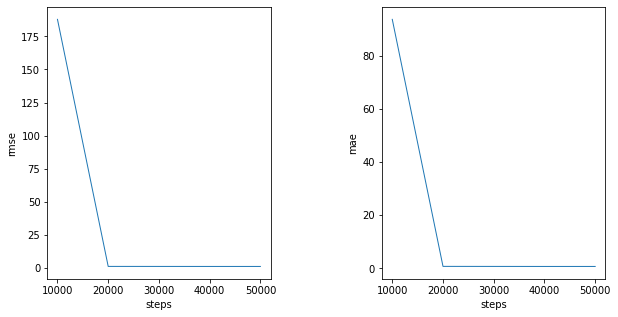

In [ ]:
if EVALUATE_WHILE_TRAINING:
    logs = evaluation_logger.get_log()
    for i, (m, v) in enumerate(logs.items(), 1):
        sb.glue("eval_{}".format(m), v)
        x = [save_checkpoints_steps*i for i in range(1, len(v)+1)]
        plot.line_graph(
            values=list(zip(v, x)),
            labels=m,
            x_name="steps",
            y_name=m,
            subplot=(math.ceil(len(logs)/2), 2, i),
        )

In [ ]:
if len(RATING_METRICS) > 0:
    predictions = list(model.predict(input_fn=tf_utils.pandas_input_fn(df=test)))
    prediction_df = test.drop(RATING_COL, axis=1)
    prediction_df[PREDICT_COL] = [p['predictions'][0] for p in predictions]
    
    rating_results = {}
    for m in RATING_METRICS:
        result = evaluator.metrics[m](test, prediction_df, **cols)
        sb.glue(m, result)
        rating_results[m] = result
    print(rating_results)

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow_estimator/python/estimator/canned/linear.py:1478: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  getter=tf.compat.v1.get_variable)


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/6240_project/project_data/wd/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'rmse': 0.8858806373433523, 'mae': 0.717226746851823}


In [ ]:
evaluation_logger.get_log()

{'mae': [93.8064999128572,
  0.7546395692850846,
  0.7406680723021339,
  0.72806198899027,
  0.7281055998877257],
 'rmse': [187.96323590337204,
  0.930676813197591,
  0.9112185091127017,
  0.8981658694926892,
  0.8944080215583602]}